# 3.0 Pre-processing and Training

Contents

3.1 [Introduction](#3.1)

  * [3.1.1 Problem Recap](#3.1.1)
  * [3.1.2 Notebook Goals](#3.1.2)
 
3.2 [Load the data](#3.2)

  * [3.2.1 Imports](#3.2.1)
  * [3.2.2 Load the data](#3.2.2)

3.3 [Examine Class Split](#3.3)

3.4 [Pre-processing](#3.4)

  * [3.4.1 Set Random Seed for Reproducability](#3.4.1)
  * [3.4.2 Train/test Split](#3.4.2)
  * [3.4.3 Examine Class Split for Train/Test Data](#3.4.3)
  

3.5 [Building some Initial Models](#3.5)
  * 3.5.1 [Logistic Regression with Count Vectorization](#3.5.1)
<br/><br/>
    * [3.5.1.1 Training and Fitting the Model](#3.5.1.1)
    * [3.5.1.2 Evaluating the Model](#3.5.1.2)
<br/><br/>
  * 3.5.2 [Logistic Regression with TFIDF Vectorization](#3.5.2)
<br/><br/>
    * [3.5.2.1 Training and Fitting Model](#3.5.2.1)
    * [3.5.2.2 Evaluating the Model](#3.5.2.2)
<br/><br/>
  * 3.5.3 [Naive Bayes](#3.5.3)
<br/> <br/> 
    * [3.5.3.1 Training and Fitting the Model](#3.5.3.1)
    * [3.5.3.2 Evaluating the Model](#3.5.3.2)
<br/> <br/>
  * 3.5.4 [Random Forest Classifier](#3.5.4)
<br/>  <br/>
    * [3.5.4.1 Training and Fitting the Model](#3.5.4.1)
    * [3.5.4.2 Evaluating the Model](#3.5.4.2)

3.6 [Conclusions](#3.6)
  * 3.6.1 [Conclusions](#3.6.1)
  * 3.6.2 [Next Steps](#3.6.2)

## 3.1 Introduction <a name="3.1"></a>

### 3.1.1 Problem Recap <a name="3.1.1"><a/>

Using customer text data about amazon products, we will build, evaluate and compare models to estimate the probability that a given text review can be classified as “positive” or “negative”.

Our goal is to build a text classifier using Amazon product review data which can be used to analyze customer sentiment which does not have accompanying numeric data. The metric we will be primarily interested in will be Recall on the positive class. This is the proportion of the positive class (negative reviews coded as "1" in the data) we correctly predict.

### 3.1.2 Notebook Goals <a name="3.1.2"></a>

1. Examine the split between the class we're trying to predict.

2. Split the data into train and test sets.

3. Convert our text review data into numeric features. (CountVectorization, TFIDF, and word2vec are options)

4. Build a few simple, initial predictive models.

5. Logistic Regression predicts probabilities. With "positive" (0) and "negative" (1) review, we can do a binary classification.

6. Measure the performance of the model with a Classification Report, Confusion Matrix and ROC + AUC.

## 3.2 Load the data <a name="3.2"><a/>

### 3.2.1 Imports <a name="3.2.1"><a/>

In [29]:
from random import seed

#reading/processing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

#splitting the dataset
from sklearn.model_selection import train_test_split

#scaling/vectorization
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier

#metrics
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, RocCurveDisplay

### 3.2.2 Load the data <a name="3.2.2"><a/>

In [30]:
data = pq.read_table("../data/edited/fashion.parquet")
fashion = data.to_pandas()

In [31]:
fashion.head()

,review,neg_sentiment,stars,review_length
0,exactly needed,0,5,4
1,agree review opening small bent hook expensiv...,1,2,49
2,love going order pack work including losing ea...,0,4,50
3,tiny opening,1,2,4
4,okay,1,3,1


In [32]:
fashion.describe()

,neg_sentiment,stars,review_length
count,873352.000000,873352.000000,873352.000000
mean,0.304939,3.904786,29.131591
std,0.460382,1.419361,39.372047
min,0.000000,1.000000,1.000000
25%,0.000000,3.000000,7.000000
50%,0.000000,5.000000,17.000000
75%,1.000000,5.000000,36.000000
max,1.000000,5.000000,2196.000000


In [33]:
fashion.shape

(873352, 4)

## 3.3 Examine Class Split <a name="3.3"><a/>

In [34]:
def plot_sentiment_split(df_col:pd.Series):
    """
    Plot the split between our positive and negative classes
    """
    df_col.value_counts().plot(kind="pie")
    plt.legend(labels=("Positive Reviews","Negative Reviews"))
    plt.title("Review Sentiment Split")
    plt.show()

    positive, negative = df_col.value_counts(normalize=True).values

    pos_perc = round(positive * 100, 2)
    neg_perc = round(negative * 100, 2)
    print(f"Positive reviews: {pos_perc}%\n", f"Negative reviews: {neg_perc}%")

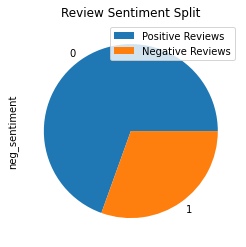

Positive reviews: 69.51%
 Negative reviews: 30.49%


In [35]:
plot_sentiment_split(fashion["neg_sentiment"])

We have more than double the positive reviews vs. negative reviews. The class we are trying to predict is negative reviews which are coded as "1".

## 3.4 Pre-Processing <a name="3.4"><a/>

### 3.4.1 Set Random Seed for Reproducability <a name="3.4.1"><a/>

In [36]:
seed(42)

### 3.4.2 Train/Test Split <a name="3.4.2"><a/>

In [37]:
#split into train and test with a 90% / 10% ratio

X_train, X_test, y_train, y_test = train_test_split(fashion["review"].values, fashion["neg_sentiment"], test_size = .1)

### 3.4.3 Examine Class Split for Train/Test Data <a name="3.4.3"><a/>

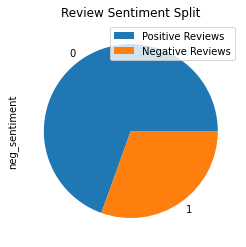

Positive reviews: 69.5%
 Negative reviews: 30.5%


In [38]:
plot_sentiment_split(y_train)

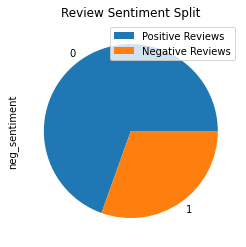

Positive reviews: 69.52%
 Negative reviews: 30.48%


In [39]:
plot_sentiment_split(y_test)

#### Both the training and test data after splitting is very representative of the split of the entire dataset (roughly .1 percent difference).

In [40]:
#convert to 1d arrays for modeling
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

## 3.5 Building Models <a name="3.5"><a/>

### 3.5.1 Logistic Regression with Count Vectorization <a name="3.5.1"><a/>

#### 3.5.1.1 Training and Fitting the Model <a name="3.5.1.1"><a/>

In [41]:
#Trying a logistic model with simple bag-of-words Count Vectorization

count_vec = CountVectorizer()

#fit the vectorizer on the training data
count_vec.fit(X_train)

#transform both the training and test data
X_train_vec = count_vec.transform(X_train)
X_test_vec = count_vec.transform(X_test)



print(X_train_vec.shape, type(X_train_vec), X_test.shape)
print(y_train.shape, y_test.shape)

#Using the sklearn StandardScaler to normalize the data, with a "with_mean" parameter for sparse matrices
scaler = StandardScaler(with_mean=False)

#fit on the training data, scale both train and text
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

#using the default solver
lr = LogisticRegression(solver = "lbfgs", n_jobs=-1, max_iter=1000)

#train the lr model with the training data
lr.fit(X_train_vec, y_train)

#predict on the training data
train_preds = lr.predict(X_train_vec)


#predict on the test data
test_preds = lr.predict(X_test_vec)


(786016, 75279) <class 'scipy.sparse.csr.csr_matrix'> (87336,)
(786016,) (87336,)


##### Count Vectorized-Logistic Regression Train Set Results

In [42]:
print(classification_report(y_train, train_preds))



              precision    recall  f1-score   support

           0       0.92      0.95      0.93    546314
           1       0.87      0.81      0.84    239702

    accuracy                           0.90    786016
   macro avg       0.89      0.88      0.88    786016
weighted avg       0.90      0.90      0.90    786016



### Evaluating the model <a name="3.5.1.2"><a/>

##### Count Vectorized-Logistic Regression Test Set Results

In [43]:
#Create a dictionary to store the results for each model to compare at the end of the notebook.
results_dict = {}

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     60719
           1       0.82      0.76      0.78     26617

    accuracy                           0.87     87336
   macro avg       0.86      0.84      0.85     87336
weighted avg       0.87      0.87      0.87     87336

Confusion matrix values: 
[[56170  4549]
 [ 6502 20115]]


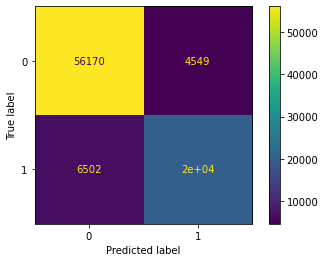

In [44]:
print(classification_report(y_test, test_preds))

results_dict["Logistic Regression with Count Vectorization"] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()


##### Summary

Our first Logistic regression model has fairly good metrics on our majority class (0) but worse on the minority class (1) that we really care about predicting. 

Recall  =  True Positives / (True Positives + False Negatives)

Our recall is only .76 on the test set for the positive class. We are predicting 20190 of our positives data points correctly vs 6445 of them incorrectly. We'll try using TF-IDF vectorization instead and see if that impoves our results. 

### 3.5.2 Logistic Regression with Term-Frequency Inverse Document Frequency Vectorization <a name="3.5.2"><a/>

#### 3.5.2.1 Training and Fitting the Model <a name="3.5.2.1"><a/>

In [45]:
#Trying a logistic model with Tfidf Vectorization

#instantiate tfidf using a max_df to eliminate the most common words (uni-gram and bi-grams) in 90%+ of reviews
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9)

#fit the vectorizer on the training data
tfidf.fit(X_train)

#transform both the training and test data
X_train_vec = tfidf.transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(X_train_vec.shape, X_test.shape)
print(y_train.shape, y_test.shape)

#using the default solver
lr = LogisticRegression(solver = "lbfgs", n_jobs=-1, max_iter=1000)

#train the lr model with the training data
lr.fit(X_train_vec, y_train)

#predict on the training data
train_preds = lr.predict(X_train_vec)

#predict on the test data
test_preds = lr.predict(X_test_vec)


(786016, 2310780) (87336,)
(786016,) (87336,)


Note the MUCH larger size of the sparse matrix created by the TFIDF model. Because of the additional size added by using bigrams, we have over 2 million column features instead of the 75,000 created by the Count Vectorizor. This proved to be a problem for some sklearn solvers (which did not converge) as well as the random forest model (out-of-memory errors). The small Count Vectorized data worked better for those models. A possible solution would be to switch to a local pyspark cluster to increase the memory available.

##### Tfidf-Logistic Regression Training set results

In [46]:
print(classification_report(y_train, train_preds))

print(f"Confusion matrix values: \n{confusion_matrix(y_train, train_preds)}")


              precision    recall  f1-score   support

           0       0.93      0.96      0.95    546314
           1       0.90      0.85      0.87    239702

    accuracy                           0.92    786016
   macro avg       0.92      0.90      0.91    786016
weighted avg       0.92      0.92      0.92    786016

Confusion matrix values: 
[[523840  22474]
 [ 36996 202706]]


##### Tfidf-Logistic Regression Test Set Results

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     60719
           1       0.86      0.80      0.83     26617

    accuracy                           0.90     87336
   macro avg       0.89      0.87      0.88     87336
weighted avg       0.90      0.90      0.90     87336

Confusion matrix values: 
[[57352  3367]
 [ 5218 21399]]


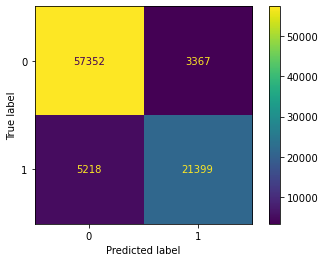

In [47]:
print(classification_report(y_test, test_preds))

results_dict["Logistic Regression with TFIDF Vectorization"] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()



#### Evaluating the Model <a name="3.5.2.2"><a/>

Logistic regression with TFIDF vectorization has better metrics than with Count Vectorization. Due to including bigrams (and possibly disallowing the most common words via max_df of .9) the TFIDF vectorization encodes more information about the data, but results in a much larger input matrix to the model.

Recall  =  True Positives / (True Positives + False Negatives)

Our recall is only .81 (vs .76 for Count Vec.) on the test set for the positive class. We are predicting 21560 of our positives data points correctly vs 5214 of them incorrectly. Though we don't care quite as much about the negative class, our metrics for it are also better than the LR model with Count Vectorization.

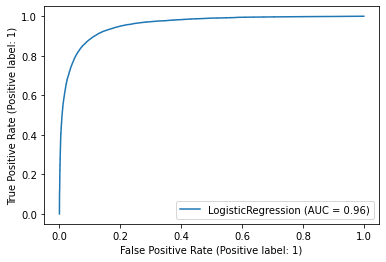

In [48]:
RocCurveDisplay.from_estimator(lr, X_test_vec, y_test)


Examining the ROC curve we see a very high AUC (.96). The curve is showing the TPR vs FPR for each possible cut-off for the probabilities output by the Logistic Regression model. 

The model gives a probability for a positive or negative prediction for each individual data point and then chooses the best cutoff. The curve shows how this varies across a range of different cut offs points ranging from 0-1.

## 3.5.3 Naive Bayes with Count Vectorization <a name="3.5.3"><a/>

#### 3.5.3.1 Training and Fitting the Model <a name="3.5.3.1"><a/>

In [49]:
#Trying a Naive Bayesian model with simple bag-of-words Count Vectorization

count_vec = CountVectorizer()

#fit the vectorizer on the training data
count_vec.fit(X_train)

#transform both the training and test data
X_train_vec = count_vec.transform(X_train)
X_test_vec = count_vec.transform(X_test)

print(X_train_vec.shape, type(X_train_vec), X_test.shape)
print(y_train.shape, y_test.shape)

#using the sklearn StandardScaler to normalize the data, with a "with_mean" parameter for sparse matrices
scaler = StandardScaler(with_mean=False)

#fit on the training data, scale both train and text
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

#using the complement version of naive bayes which accepts sparse matrices as input
#it also is supposed to work well for imbalanced datasets
comp_nb = ComplementNB()

#train the lr model with the training data
comp_nb.fit(X_train_vec, y_train)

#predict on the training data
train_preds = comp_nb.predict(X_train_vec)

#predict on the test data
test_preds = comp_nb.predict(X_test_vec)


(786016, 75279) <class 'scipy.sparse.csr.csr_matrix'> (87336,)
(786016,) (87336,)


##### Naive Bayes Train Set Results

In [50]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87    546314
           1       0.67      0.85      0.75    239702

    accuracy                           0.83    786016
   macro avg       0.80      0.83      0.81    786016
weighted avg       0.85      0.83      0.83    786016



#### 3.5.3.2 Evaluating the Model <a name="3.5.3.2"><a/>

##### Naive Bayes Test Set Results

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     60719
           1       0.64      0.81      0.72     26617

    accuracy                           0.80     87336
   macro avg       0.77      0.81      0.78     87336
weighted avg       0.83      0.80      0.81     87336

Confusion matrix values: 
[[48789 11930]
 [ 5125 21492]]


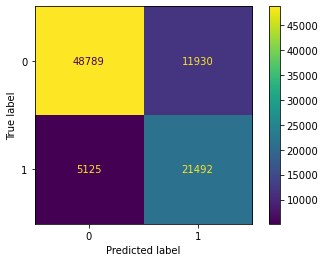

In [51]:
print(classification_report(y_test, test_preds))

#saving the results
results_dict["Naive Bayes with Count Vectorization"] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()



The Naive Bayes model is giving a fairly good recall of .80 on the positive class we are predicting, but interestingly predicts a much higher number of the negative class incorrectly (notice the low precision).



Precision  =  True Positives / (True Positives + False Positives)


In [52]:
precision = 21624 / (21624 + 12062)

print(f"Precision of our Naive Bayes model: \t{precision}")

Precision of our Naive Bayes model: 	0.64192839755388


## 3.5.4 Random Forest Classifier with Count Vectorizations <a name="3.5.4"><a/>

#### 3.5.4.1 Training and Fitting the Model <a name="3.5.4.1"><a/>

In [53]:
#Trying a Random Forest model with simple bag-of-words Count Vectorization

count_vec = CountVectorizer()

#fit the vectorizer on the training data
count_vec.fit(X_train)

#transform both the training and test data
X_train_vec = count_vec.transform(X_train)
X_test_vec = count_vec.transform(X_test)

print(X_train_vec.shape, type(X_train_vec), X_test.shape)
print(y_train.shape, y_test.shape)

#Since Random Forest models use linear decision boundaries, it should not need scaled input data

#using the default solver
rfc = RandomForestClassifier(max_leaf_nodes=2000, min_samples_leaf=3)

#train the lr model with the training data
rfc.fit(X_train_vec, y_train)

#predict on the training data
train_preds = rfc.predict(X_train_vec)


#predict on the test data
test_preds = rfc.predict(X_test_vec)


(786016, 75279) <class 'scipy.sparse.csr.csr_matrix'> (87336,)
(786016,) (87336,)


#### 3.5.4.2 Evaluating the Model <a name="3.5.4.2"><a/>

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     60719
           1       0.90      0.61      0.72     26617

    accuracy                           0.86     87336
   macro avg       0.87      0.79      0.82     87336
weighted avg       0.86      0.86      0.85     87336

Confusion matrix values: 
[[58823  1896]
 [10404 16213]]


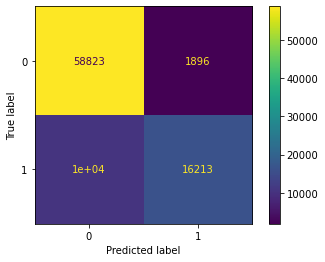

In [54]:
print(classification_report(y_test, test_preds))

#saving the results
results_dict["Random Forest with Count Vectorization"] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()


##### Summary
It seems like this model is STONGLY overfitting our training data. The recall on the test set for our positive class (1) is only .61 which is very poor. We are seeing a very high number of False Negatives (~10000) which results in the poor recall for our positive class. This could possibly be due to leaf sizes and might also be mitigated by adjusting the proportion of our positive class in the training data (under or over sampling).

## 3.6 Conclusions <a name="3.6"><a/>

### 3.6.1 Preprocessing and Training Summary <a name="3.6.1"><a/>

In [55]:
for model in results_dict:
    print(model, results_dict[model], sep="\n")

Logistic Regression with Count Vectorization
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     60719
           1       0.82      0.76      0.78     26617

    accuracy                           0.87     87336
   macro avg       0.86      0.84      0.85     87336
weighted avg       0.87      0.87      0.87     87336

Logistic Regression with TFIDF Vectorization
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     60719
           1       0.86      0.80      0.83     26617

    accuracy                           0.90     87336
   macro avg       0.89      0.87      0.88     87336
weighted avg       0.90      0.90      0.90     87336

Naive Bayes with Count Vectorization
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     60719
           1       0.64      0.81      0.72     26617

    accuracy                           0.80     87336
 

#### Model Results on Test Set:
Examining the four models we built, using the Recall on the positive class as our primary metric, it looks like the most successful model was the Logistic Regression with TFIDF. Both it and the Naive Bayes model had a recall of .80 on the positive class. The Naive Bayes overall had worse metrics on the other ("0") class, incorrectly predicting a higher number of them as the positive class.

### 3.6.2 Next Steps <a name="3.6.2"><a/>

1. Check if under-sampling the majority class ("0"s) or over-sampling the minority class ("1"s) can improve our results.

2. Test some other models such as XGBoost or SVMs. XGBoost could give better results than the strongly-overfit Random Forest model.

3. We should try using cross-validation to get a better sense of how well our models will generalize.

4. One of the challenges in this notebook was how much the models struggled with the larger vectors created by the TFIDF model. We could further experiment with TFIDF parameters or possibly train on a smaller sample size.

5. Hyper-parameter tuning with grid-search or bayesian search optimization could be used for our best/most promising models in the next notebook.
